In [1]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from collections import deque

from tqdm import tqdm
from subprocess import run

# plt.rcParams['animation.writer'] = 'ffmpeg'
import imageio

In [50]:
class box_with_particles:
    def __init__(self, dt = 0.1, t_stop = 2.5, box_length = [1,1], number_of_particles = 1, particle_radius = 0.05, vfactor = 2) -> None:

        self.dt = dt
        self.t_stop = t_stop
        self.time_list = np.arange(0, t_stop, dt)
        self.number_of_time_steps = len(self.time_list)
        self.box_length = box_length
        self.box_length_x = box_length[0]
        self.box_length_y = box_length[1]
        self.number_of_particles = number_of_particles
        self.particle_radius = particle_radius
        self.hitting_distance = 2*particle_radius

        self.vfactor = vfactor

        self.x_list = np.zeros( ( len(self.time_list), self.number_of_particles ))
        self.y_list = np.zeros( ( len(self.time_list), self.number_of_particles ))

        self.vx_list = np.zeros( ( len(self.time_list), self.number_of_particles ))
        self.vy_list = np.zeros( ( len(self.time_list), self.number_of_particles ))

        self.current_it = 0

        self.hitting_particles_list = []

        self.color_list = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

        return

    def set_initial_positions(self, initial_positions_x, initial_positions_y):
        for i in range(self.number_of_particles):
            self.x_list[0, i] = initial_positions_x[i]
            self.y_list[0, i] = initial_positions_y[i]
        return

    def set_initial_positions_random(self):
        frame = 0.05
        for i in range(self.number_of_particles):
            x = np.random.rand() * self.box_length_x*(1-2*frame) + self.box_length_x*frame
            y = np.random.rand() * self.box_length_y*(1-2*frame) + self.box_length_y*frame
            self.x_list[0, i] = x
            self.y_list[0, i] = y
        return
    
    def set_initial_velocities(self, initial_velocities_x, initial_velocities_y):
        for i in range(self.number_of_particles):
            self.vx_list[0, i] = initial_velocities_x[i]
            self.vy_list[0, i] = initial_velocities_y[i]
        return
    
    def set_initial_velocities_random(self):
        for i in range(self.number_of_particles):
            v_theta = np.random.rand() * 2*np.pi
            vx = np.cos(v_theta)
            vy = np.sin(v_theta)
            self.vx_list[0, i] = vx*self.vfactor
            self.vy_list[0, i] = vy*self.vfactor
        return
    
    def prepare_simulation_random(self):
        self.set_initial_positions_random()
        self.set_initial_velocities_random()
        return

    def make_time_step(self):
        self.current_it += 1
        it = self.current_it
        for i in range(self.number_of_particles):
            vx = self.vx_list[it-1, i]
            vy = self.vy_list[it-1, i]
            self.x_list[it, i] = self.x_list[it-1, i] + vx*self.dt
            self.y_list[it, i] = self.y_list[it-1, i] + vy*self.dt
            
            self.vx_list[it, i] = vx
            self.vy_list[it, i] = vy

        # Update velocities
        for i in range(self.number_of_particles):
            self.update_velocities(vx, vy, it, i)

        return
    
    def update_velocities(self, vx, vy, it, i):

        # CHECKING IF THE PARTICLE IS HITTING ANOTHER PARTICLE
        for i2 in range(i+1, self.number_of_particles):
            dx = self.x_list[it, i2] - self.x_list[it, i]
            dy = self.y_list[it, i2] - self.y_list[it, i]
            distance = np.sqrt(dx*dx + dy*dy)
            
            if distance < self.hitting_distance:
                if [i, i2] not in self.hitting_particles_list and [i2, i] not in self.hitting_particles_list:
                    # exchange velocities
                    vx_buffer = self.vx_list[it, i].copy()
                    vy_buffer = self.vy_list[it, i].copy()
                    self.vx_list[it, i] = self.vx_list[it, i2].copy()
                    self.vy_list[it, i] = self.vy_list[it, i2].copy()
                    self.vx_list[it, i2] = vx_buffer.copy()
                    self.vy_list[it, i2] = vy_buffer.copy()

                    self.hitting_particles_list.append([i, i2])
                    
            elif distance > 0.5:
                if [i, i2] in self.hitting_particles_list:
                    self.hitting_particles_list.remove([i, i2])
                elif [i2, i] in self.hitting_particles_list:
                    self.hitting_particles_list.remove([i2, i])
    
        # CHECKING IF THE PARTICLE IS GETTING OUTSIDE THE BOX
        # For x-axis
        if self.x_list[it, i] < 0 or self.x_list[it, i] > self.box_length_x:
            self.vx_list[it, i] *= -1.0
        # For y-axis
        if self.y_list[it, i] < 0 or self.y_list[it, i] > self.box_length_y:
            self.vy_list[it, i] *= -1.0


        return

    def run_simulation(self):
        for step in tqdm( range(self.number_of_time_steps-1) ):
            self.make_time_step()
        return

In [65]:
print('Running simulation')
number_of_particles = 30
vfactor = 2
simulation = box_with_particles(dt = 0.025, t_stop = 60, box_length = [3,2], number_of_particles = number_of_particles, particle_radius=0.05, vfactor=vfactor)
simulation.prepare_simulation_random()
simulation.run_simulation()

Running simulation


100%|██████████| 2399/2399 [00:02<00:00, 909.12it/s]



Creating animation
number of time steps = 2400


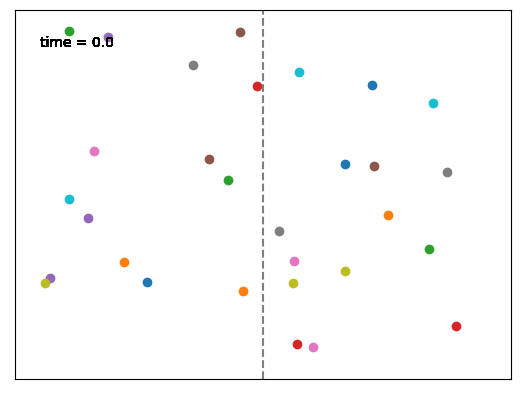

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

CompletedProcess(args='echo "y" | ffmpeg -f gif -i animation30v2.gif animation30v2.mp4', returncode=0)

In [66]:
print('\nCreating animation')
print('number of time steps = %.0f' % (simulation.number_of_time_steps))
# simulation.create_animation()

# Create the figure and axes
fig, ax = plt.subplots()
ax.set_xlim(0, simulation.box_length_x)
ax.set_ylim(0, simulation.box_length_y)

# Initialize the lines to be plotted
lines = []
time_texts = []

# Create and append line objects to the lines list
icolor = -1
number_of_colors = 10
for i in range(simulation.number_of_particles):
    icolor += 1
    if icolor >= number_of_colors:
        icolor -= number_of_colors
    line, = ax.plot([], [], 'o', color=simulation.color_list[icolor])
    lines.append(line)

    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    time_texts.append(time_text)
    
line, = ax.plot([simulation.box_length_x*0.5, simulation.box_length_x*0.5], [0, simulation.box_length_y], '--', color='tab:grey')
lines.append(line)

time_template = 'time = %.1f'

# Define the update function for the animation
def update(frame):    
    # Update the data for each line
    
    for i, line in enumerate(lines):
        if i < simulation.number_of_particles:
            line.set_data(simulation.x_list[frame, i], simulation.y_list[frame, i])

    for i, time_text in enumerate(time_texts):
        time_text.set_text(time_template % (frame*simulation.dt))
    
    return lines

# Create the animation
my_animation = animation.FuncAnimation(fig, update, frames=simulation.number_of_time_steps, interval=50, blit=True)

# Display the plot
# plt.title('Velocitats grans')
plt.xticks([])
plt.yticks([])
plt.grid()
plt.show()

writer = PillowWriter(fps=48)
file_name = 'animation' + str(number_of_particles) + 'v' + str(vfactor)
my_animation.save(file_name + '.gif', writer=writer)  # Save as GIF
run('echo "y" | ffmpeg -f gif -i ' + file_name +'.gif ' + file_name + '.mp4', shell=True)

# Plots

In [23]:
fontsize = 12

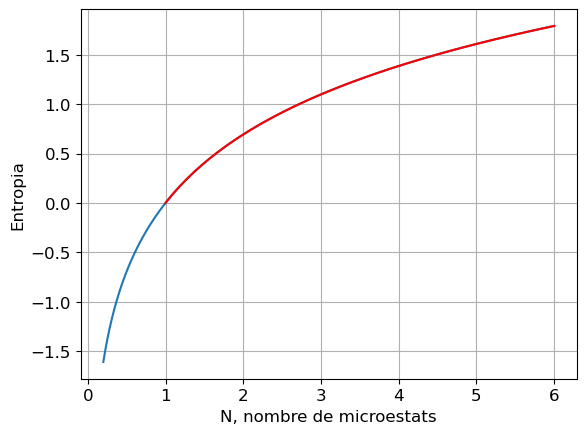

In [24]:
x = np.linspace(0.2, 6, 1000)
y = np.log(x)
x2 = np.linspace(1, 6, 1000)
y2 = np.log(x2)

plt.plot(x,y,'-')
plt.plot(x2,y2,'r-')
plt.xlabel('N, nombre de microestats', fontsize=fontsize)
plt.ylabel('Entropia', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.text(0, 1.3, 'Entropia = log(N)', fontsize=15)
plt.grid()

plt.savefig('log.png')

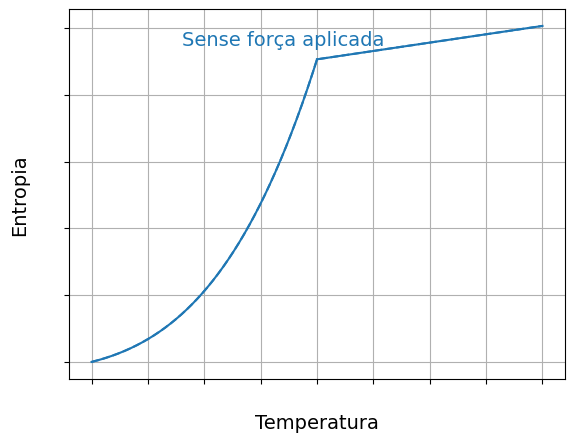

In [104]:
def plot_entropy(Tc, x0, degree, color='tab:blue', n_points=1000):
    x1 = np.linspace(0, Tc, n_points)
    y1 = (x1-x0)**degree - (-x0)**degree

    x2 = np.linspace(Tc, 2, n_points)
    m = 1
    y2 = y1[-1] + m*(x2-x1[-1])

    x = np.concatenate((x1, x2), axis=0)
    y = np.concatenate((y1, y2), axis=0)

    plt.plot(x1,y1,'-', color=color)
    plt.plot(x2,y2,'-', color=color)
    plt.plot(x,y,'--', color=color)
    plt.xlabel('Temperatura', fontsize=fontsize)
    plt.ylabel('Entropia', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(color='w')
    plt.yticks(color='w')

fontsize = 14
color1 = 'tab:blue'
color2 = 'tab:red'

x0 = -0.75
Tc = 1.
degree=4
plot_entropy(Tc, x0, degree, color=color1)
plt.text(0.4, 9.5, r'Sense força aplicada', color=color1, fontsize=fontsize)

Tc = 1.2
degree=3
# plot_entropy(Tc, x0, degree, color=color2)
# plt.text(1.2, 6.5, r'Amb força aplicada', color=color2, fontsize=fontsize)
# plt.text(1.2, 5.8, r'que ordena', color=color2, fontsize=fontsize)

plt.grid()
plt.savefig('SvsT1.png')